In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
import seaborn as sns
import time
from datetime import date
%matplotlib inline

import sklearn.metrics
import matplotlib.patches as patches

from datetime import datetime
from dateutil.parser import parse

import scipy
from scipy import signal,misc,stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10000)

from tqdm import notebook as tqdm
from tqdm import tqdm
for i in tqdm(range(10000)):
    pass

100%|██████████| 10000/10000 [00:00<00:00, 5011714.66it/s]


In [2]:
# Load in datasets
calendar = pd.read_csv('/home/steven/Udacity_Class/Project1_Blog_Post/boston/calendar.csv')
listings = pd.read_csv('/home/steven/Udacity_Class/Project1_Blog_Post/boston/listings.csv')
reviews = pd.read_csv('/home/steven/Udacity_Class/Project1_Blog_Post/boston/reviews.csv')

In [3]:
# Change column name to match other dataFrames
listings = listings.rename(columns = {'id':'listing_id'})

In [4]:
# Merge two dataFrames
boston = calendar.merge(listings, on=['listing_id'])

In [5]:
# Drop columns that contain URLs
boston = boston[boston.columns.drop(list(boston.filter(regex = 'url')))]

In [6]:
# Check number of NaNs in columns
boston.isna().sum().sort_values(ascending=False)

has_availability                    1308890
neighbourhood_group_cleansed        1308890
jurisdiction_names                  1308890
license                             1308890
square_feet                         1288450
monthly_price                        984770
weekly_price                         983310
security_deposit                     819060
notes                                720875
price_x                              665853
interaction                          567575
access                               543850
neighborhood_overview                516840
host_about                           477785
transit                              471215
house_rules                          435080
cleaning_fee                         404420
space                                386170
review_scores_accuracy               300760
review_scores_location               300395
review_scores_value                  300030
review_scores_checkin                299665
review_scores_cleanliness       

In [7]:
# Drop columns that contain only NaN values
boston = boston.drop(columns = ['has_availability', 'neighbourhood_group_cleansed', 'jurisdiction_names','license','square_feet'])

In [8]:
# The next few lines, checking score scaling
boston['review_scores_rating'][boston['review_scores_rating'].isna()!=True]

365        94.0
366        94.0
367        94.0
368        94.0
369        94.0
           ... 
1308520    90.0
1308521    90.0
1308522    90.0
1308523    90.0
1308524    90.0
Name: review_scores_rating, Length: 1011780, dtype: float64

In [9]:
boston['review_scores_accuracy'][boston['review_scores_accuracy'].isna()!=True]

365        10.0
366        10.0
367        10.0
368        10.0
369        10.0
           ... 
1308520     9.0
1308521     9.0
1308522     9.0
1308523     9.0
1308524     9.0
Name: review_scores_accuracy, Length: 1008130, dtype: float64

In [10]:
boston['review_scores_location'][boston['review_scores_location'].isna()!=True]

365        9.0
366        9.0
367        9.0
368        9.0
369        9.0
          ... 
1308520    8.0
1308521    8.0
1308522    8.0
1308523    8.0
1308524    8.0
Name: review_scores_location, Length: 1008495, dtype: float64

In [11]:
boston['review_scores_value'][boston['review_scores_value'].isna()!=True]

365        9.0
366        9.0
367        9.0
368        9.0
369        9.0
          ... 
1308520    7.0
1308521    7.0
1308522    7.0
1308523    7.0
1308524    7.0
Name: review_scores_value, Length: 1008860, dtype: float64

In [12]:
boston['review_scores_checkin'][boston['review_scores_checkin'].isna()!=True]

365        10.0
366        10.0
367        10.0
368        10.0
369        10.0
           ... 
1308520     9.0
1308521     9.0
1308522     9.0
1308523     9.0
1308524     9.0
Name: review_scores_checkin, Length: 1009225, dtype: float64

In [13]:
boston['review_scores_cleanliness'][boston['review_scores_cleanliness'].isna()!=True]

365        9.0
366        9.0
367        9.0
368        9.0
369        9.0
          ... 
1308520    8.0
1308521    8.0
1308522    8.0
1308523    8.0
1308524    8.0
Name: review_scores_cleanliness, Length: 1009955, dtype: float64

In [14]:
boston['review_scores_communication'][boston['review_scores_communication'].isna()!=True]

365        10.0
366        10.0
367        10.0
368        10.0
369        10.0
           ... 
1308520     9.0
1308521     9.0
1308522     9.0
1308523     9.0
1308524     9.0
Name: review_scores_communication, Length: 1009955, dtype: float64

In [15]:
# Changing scale of this rating to match the other rating columns
boston['review_scores_rating'] = boston['review_scores_rating']/10

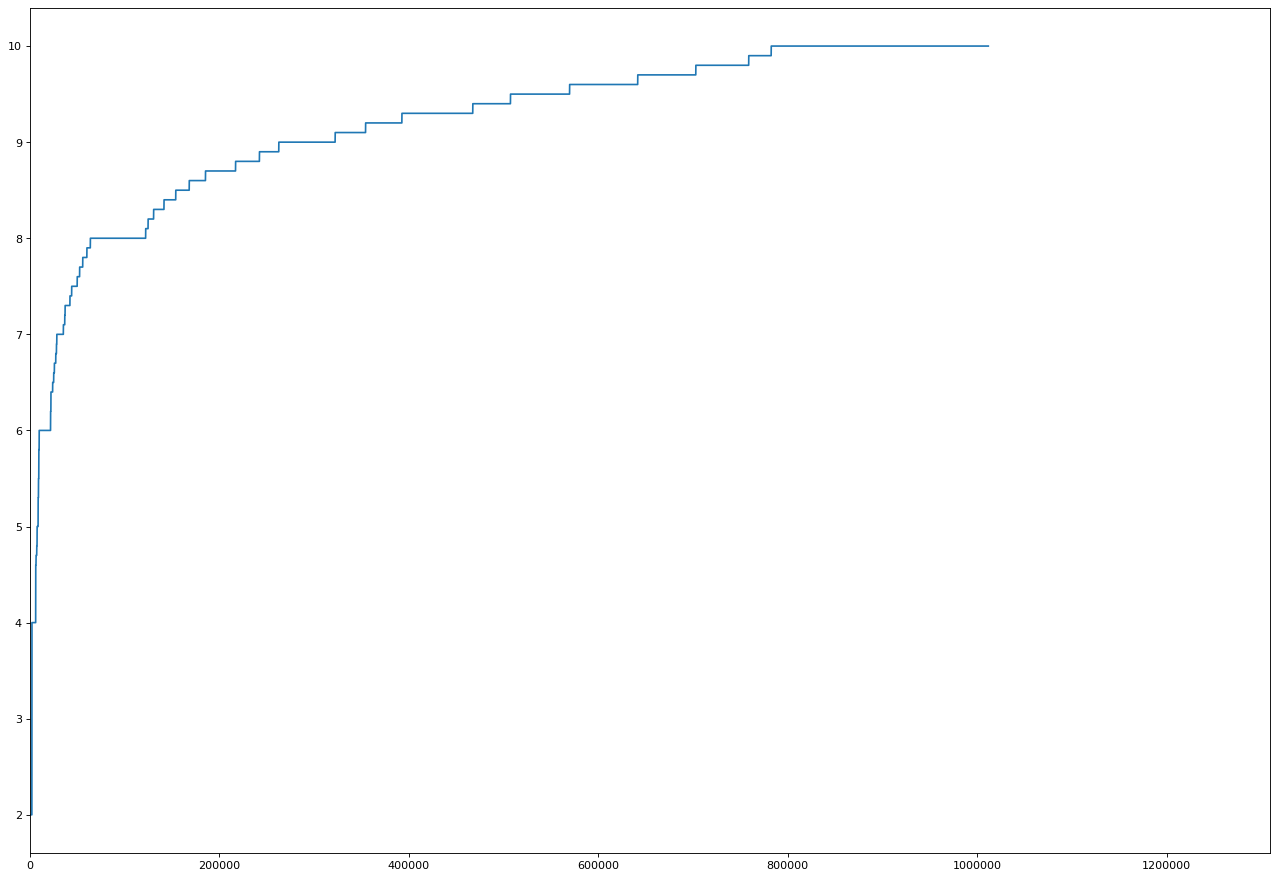

In [16]:
fig = plt.figure(figsize=(20, 14), dpi=80)
boston['review_scores_rating'].sort_values().reset_index(drop=True).plot()

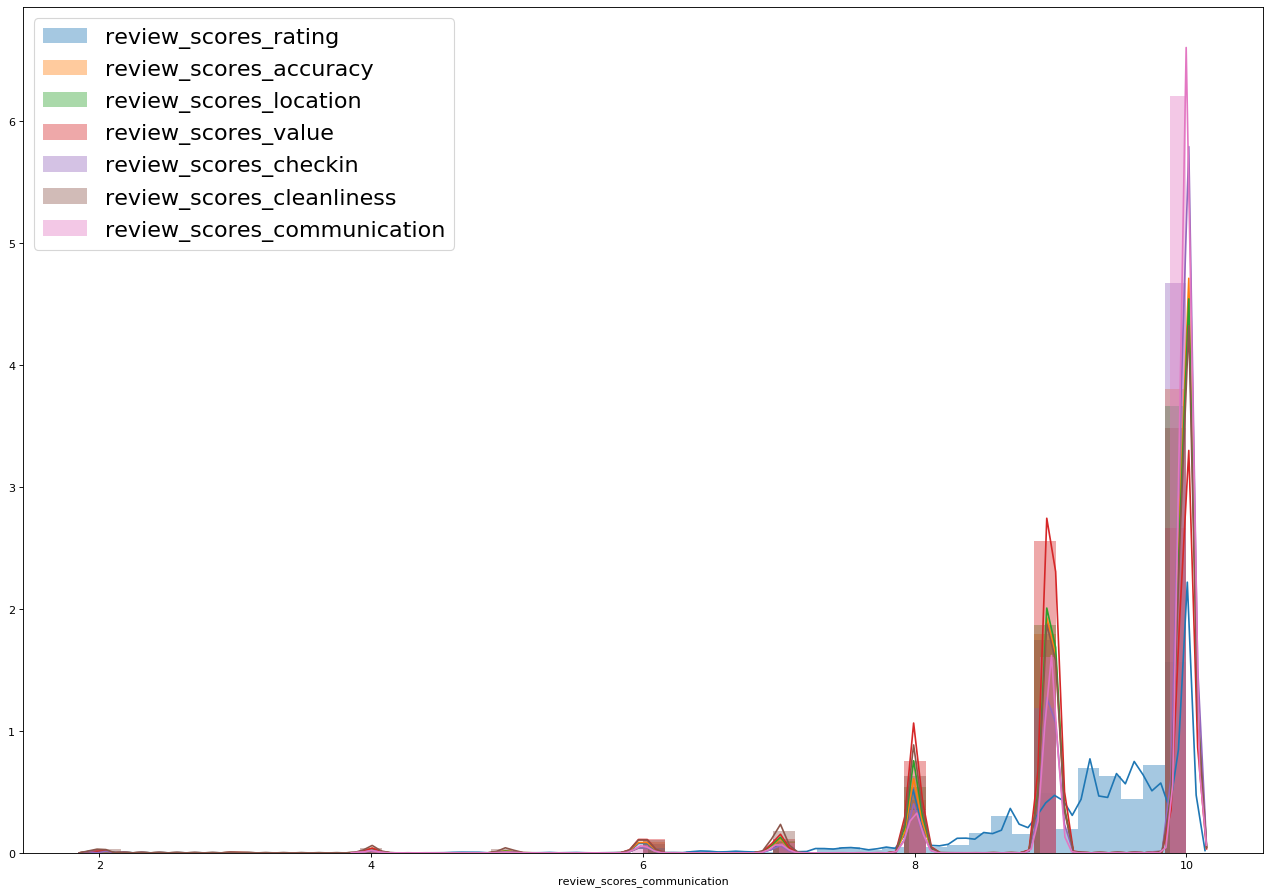

In [17]:
# Check the distribrution of scorings. 

fig = plt.figure(figsize=(20, 14), dpi=80)
sns.distplot(boston['review_scores_rating'].dropna(), label = 'review_scores_rating')
sns.distplot(boston['review_scores_accuracy'].dropna(), label = 'review_scores_accuracy')
sns.distplot(boston['review_scores_location'].dropna(), label = 'review_scores_location')
sns.distplot(boston['review_scores_value'].dropna(), label = 'review_scores_value')
sns.distplot(boston['review_scores_checkin'].dropna(), label = 'review_scores_checkin')
sns.distplot(boston['review_scores_cleanliness'].dropna(), label = 'review_scores_cleanliness')
sns.distplot(boston['review_scores_communication'].dropna(), label = 'review_scores_communication')
plt.legend(fontsize=20);

### We can see that all reviews seem to trend the same way, with most reviews being 8 or above. 

## Let's look a the most common words used in the description, and see how those correlate to the reviews

In [18]:
boston['summary'][0]

'Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation.'

In [19]:
# Split summary text into individual words and count their occurances

from collections import Counter

summary = []
for row in tqdm(boston['summary'].unique()):
    summary.append(row)
def concatenate_list_data(list):
    result= ''
    for element in list:
        result += str(element)
    return result

summary = concatenate_list_data(summary)
summary = summary.lower()

split_it = summary.split()
Counter = Counter(split_it)
most_occur = Counter.most_common(150)

description = pd.DataFrame(most_occur, columns = ['word', 'count'])

100%|██████████| 3114/3114 [00:00<00:00, 3694784.34it/s]


In [20]:
# Most common words in English

wordlist = ('the','of','to','and','a','in','is','it','you','that','he','was','for','on','are','with','as','I','his',
'they','be','at','one','have','this','from','or','had','by','not','word','but','what','some','we','can','out',
'other','were','all','there','when','up','use','your','how','said','an','each','she','which','do','their','time',
'if','will','way','about','many','then','them','write','would','like','so','these','her','long','make','thing',
'see','him','two','has','look','more','day','could','go','come','did','number','sound','no','most','people','my',
'over','know','water','than','call','first','who','may','down','side','been','now','find', '1', '2', '3', '4','5',
           '6', '7', '8', '9', '0', '&', '-', 't', 'i', 'kitchen,', 'restaurants,', 'couples,', "boston's")

In [21]:
# Checking which words in the summary match the words in the list to drop those words

description_most_common = description[~description.word.isin(wordlist)]
description_most_common = description_most_common.reset_index()
description_most_common.drop(columns = ['index']);

No handles with labels found to put in legend.


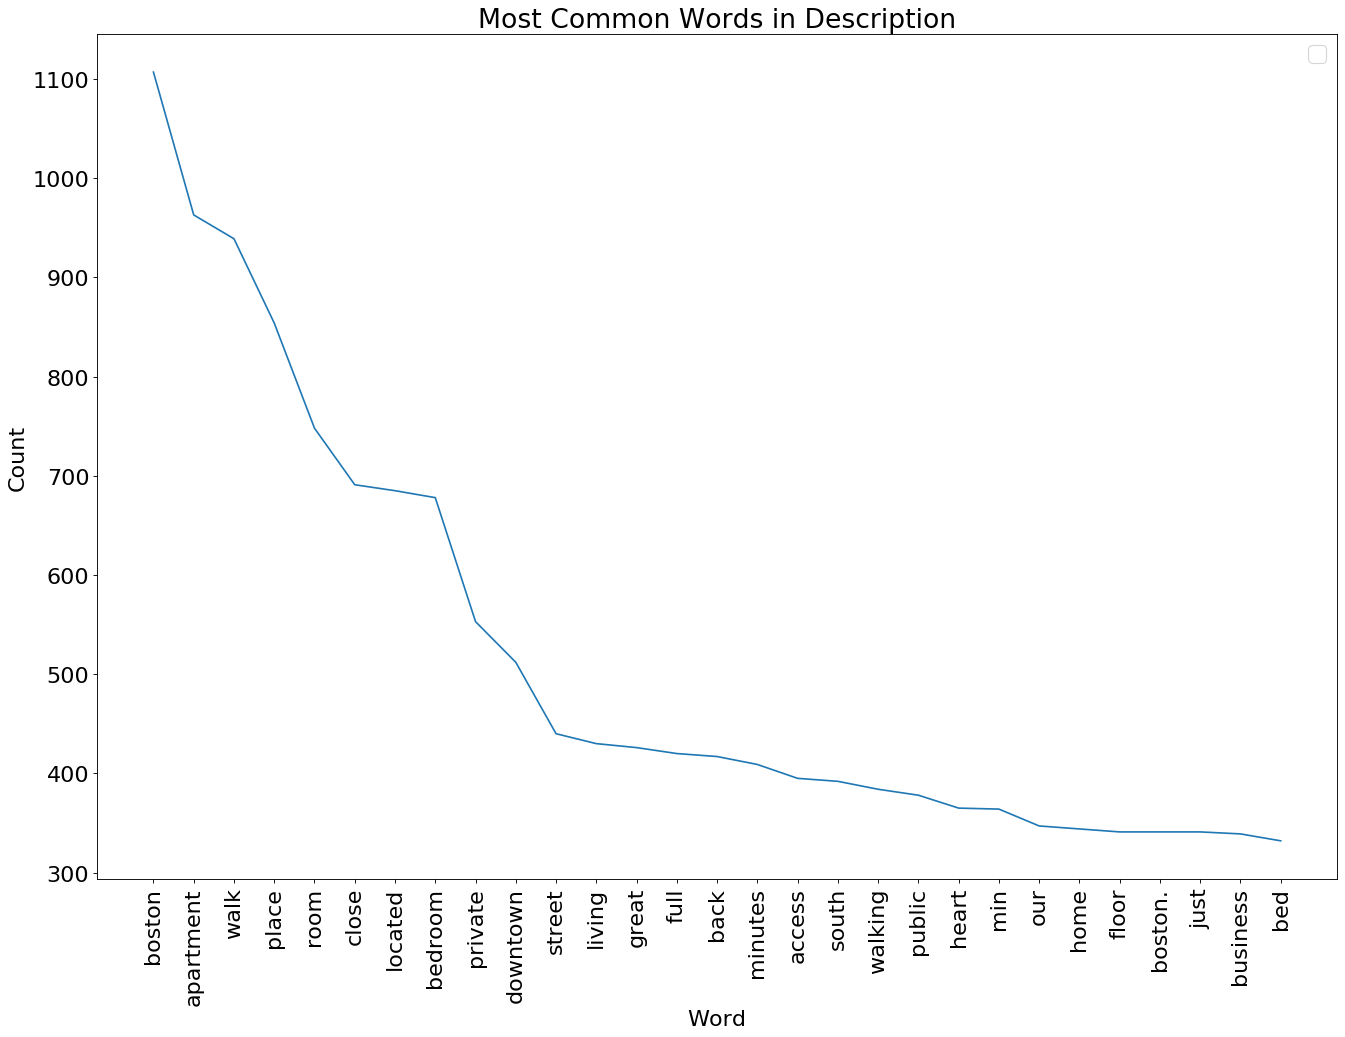

In [22]:
# Plot the most common words from the summary and their count

fig = plt.figure(figsize=(20, 14), dpi=80)
plt.plot(description_most_common['word'][:29], description_most_common['count'][:29])
plt.xlabel('Word', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.tick_params(axis='x', labelsize=20, labelrotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize = 20)
plt.title('Most Common Words in Description', fontsize = 24);

In [23]:
reviews['comments'][0]

"My stay at islam's place was really cool! Good location, 5min away from subway, then 10min from downtown. The room was nice, all place was clean. Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)"

In [24]:
# Same as above, but for the comments left on listings

from collections import Counter

summary = []
for row in tqdm(reviews['comments'].unique()):
#     print(row)
    summary.append(row)
def concatenate_list_data(list):
    result= ''
    for element in list:
        result += str(element)
    return result

summary = concatenate_list_data(summary)
summary = summary.lower()

split_it = summary.split()
Counter = Counter(split_it)
most_occur = Counter.most_common(150)

reviews = pd.DataFrame(most_occur, columns = ['word', 'count'])

100%|██████████| 67312/67312 [00:00<00:00, 2600342.54it/s]


In [25]:
reviews_most_common = reviews[~reviews.word.isin(wordlist)]
reviews_most_common = reviews_most_common.reset_index()
reviews_most_common = reviews_most_common.drop(columns = ['index']);

No handles with labels found to put in legend.


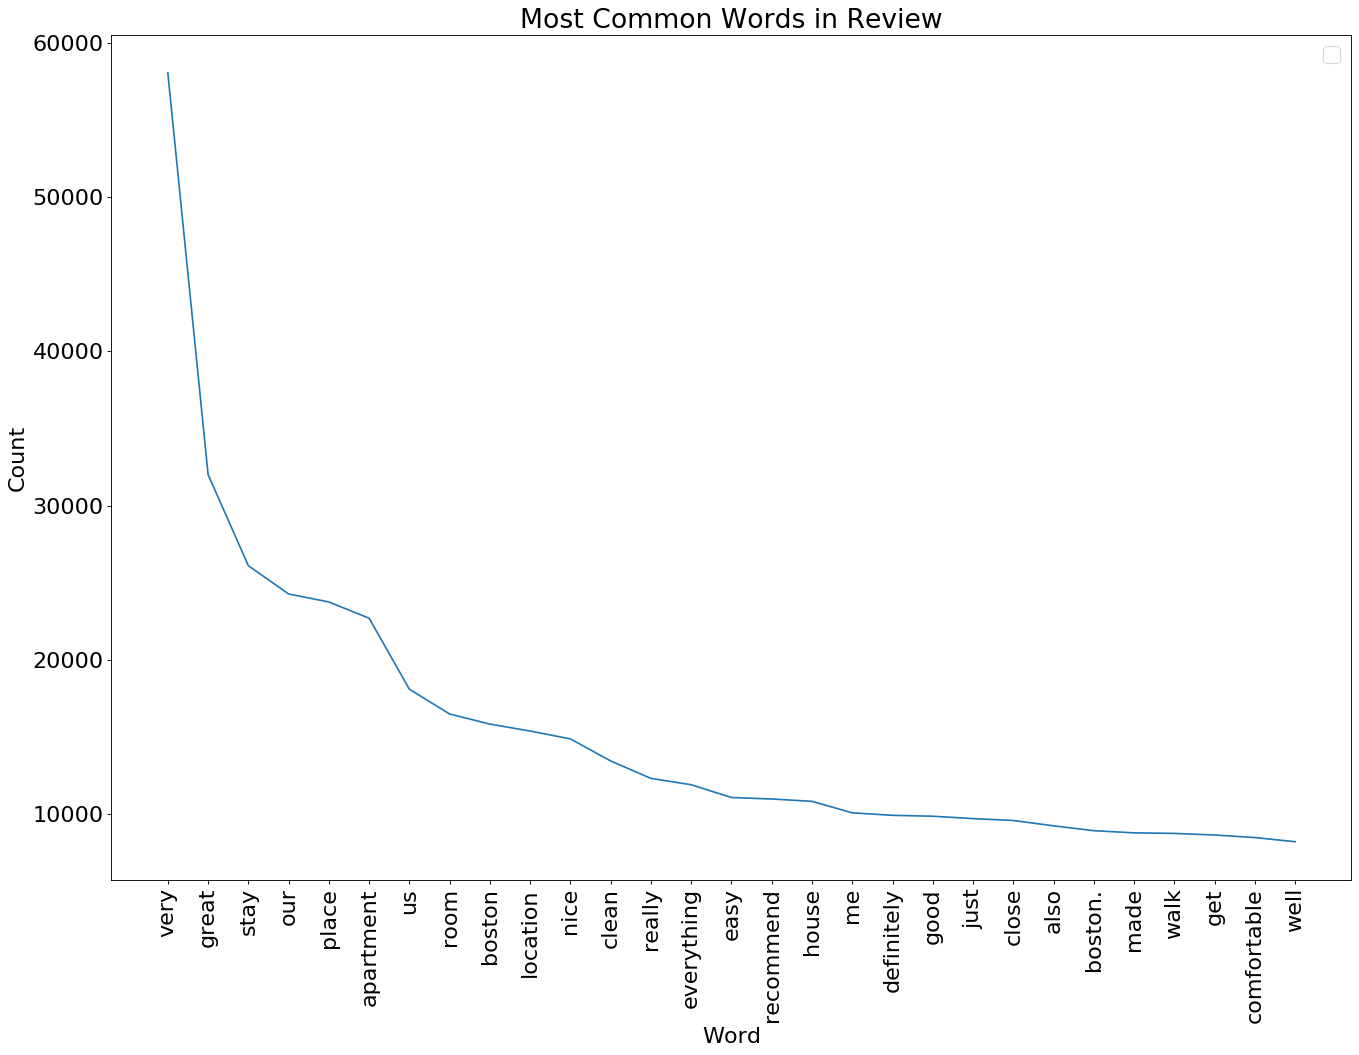

In [26]:
fig = plt.figure(figsize=(20, 14), dpi=80)
plt.plot(reviews_most_common['word'][:29], reviews_most_common['count'][:29])
plt.xlabel('Word', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.tick_params(axis='x', labelsize=20, labelrotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize = 20)
plt.title('Most Common Words in Review', fontsize = 24);

In [27]:
#Compare the two word lists against one another

most_common = description_most_common[description_most_common.word.isin(reviews_most_common.word)]
most_common = most_common.reset_index()
most_common = most_common.drop(columns = ['index'])
most_common = most_common.drop(columns = ['level_0']);

In [28]:
most_common

,word,count
0,boston,1107
1,apartment,963
2,walk,939
3,place,854
4,room,748
5,close,691
6,located,685
7,street,440
8,great,426
9,back,417


No handles with labels found to put in legend.


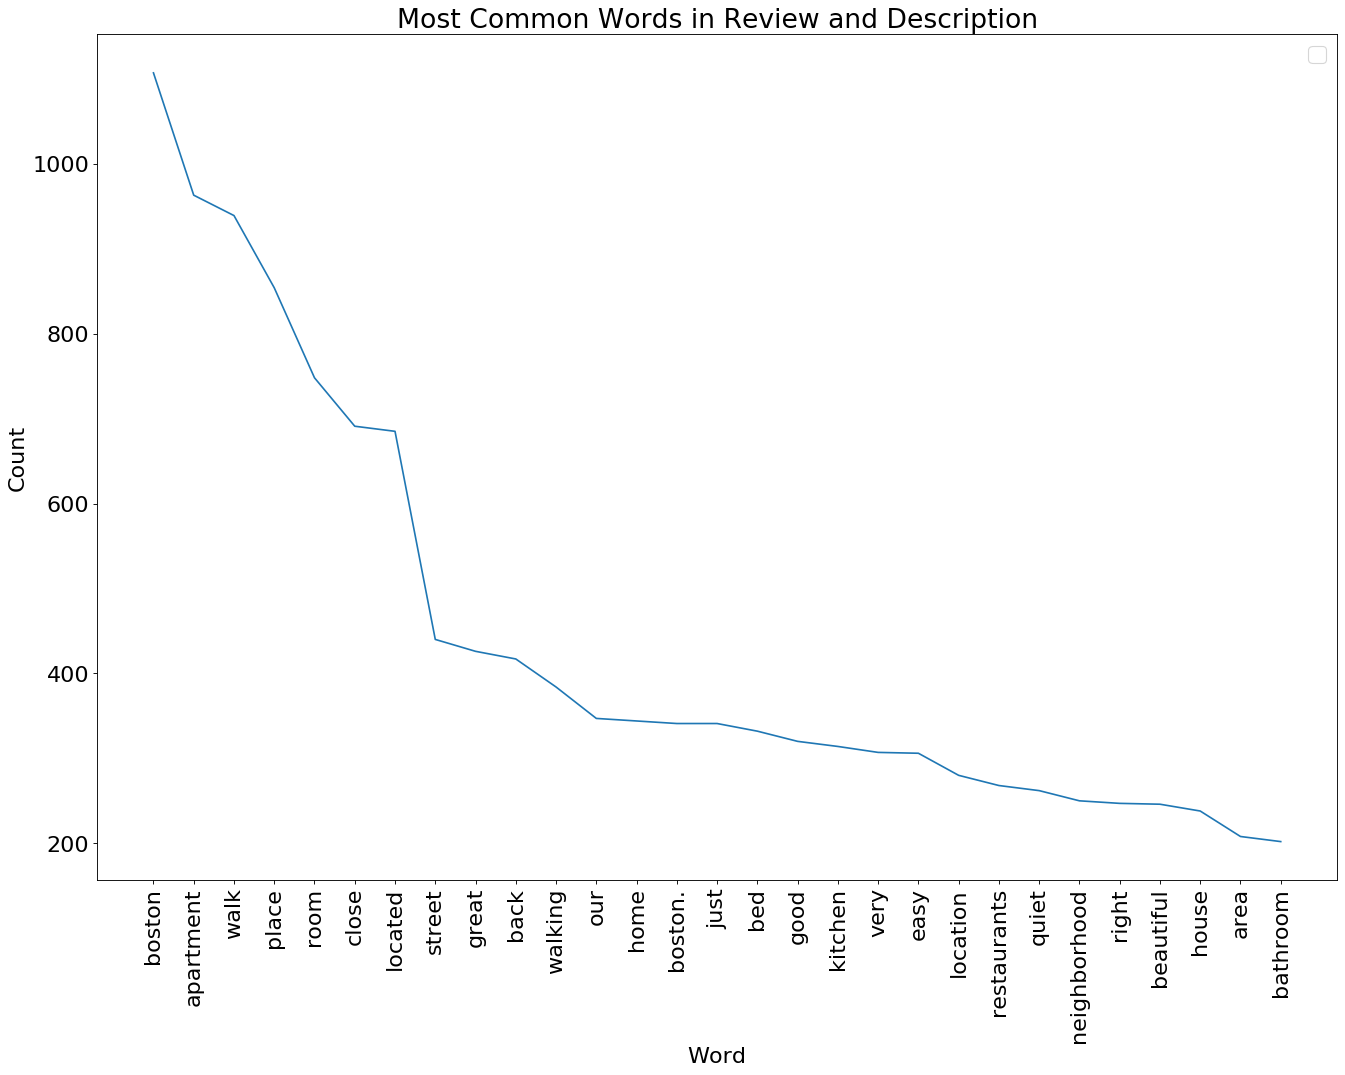

In [29]:
# Most common words that occur in both listings and comments

fig = plt.figure(figsize=(20, 14), dpi=80)
plt.plot(most_common['word'][:29], most_common['count'][:29])
plt.xlabel('Word', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.tick_params(axis='x', labelsize=20, labelrotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize = 20)
plt.title('Most Common Words in Review and Description', fontsize = 24);

## Let's Look at Prices

In [30]:
# Change structure of price data to int

listings['price'] = listings['price'].map(lambda p: int(p[1:-3].replace(",", "")))

In [31]:
# Look at only listings with a daily price of less than $600

listings = listings[listings['price']<=600]

In [32]:
listings['price'].describe()

count    3547.000000
mean      165.029039
std       101.179335
min        10.000000
25%        85.000000
50%       149.000000
75%       219.000000
max       600.000000
Name: price, dtype: float64

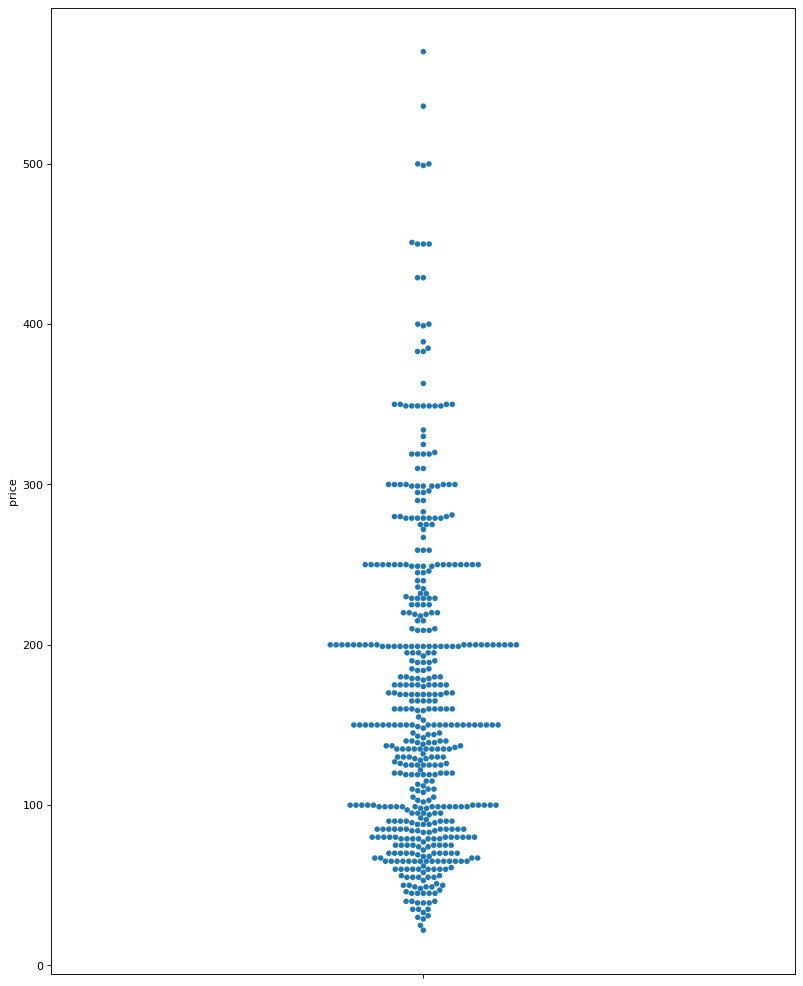

In [33]:
fig = plt.figure(figsize=(12, 16), dpi=80)
sns.swarmplot(y=listings['price'].sample(500))

100%|██████████| 25/25 [00:00<00:00, 661.55it/s]
No handles with labels found to put in legend.


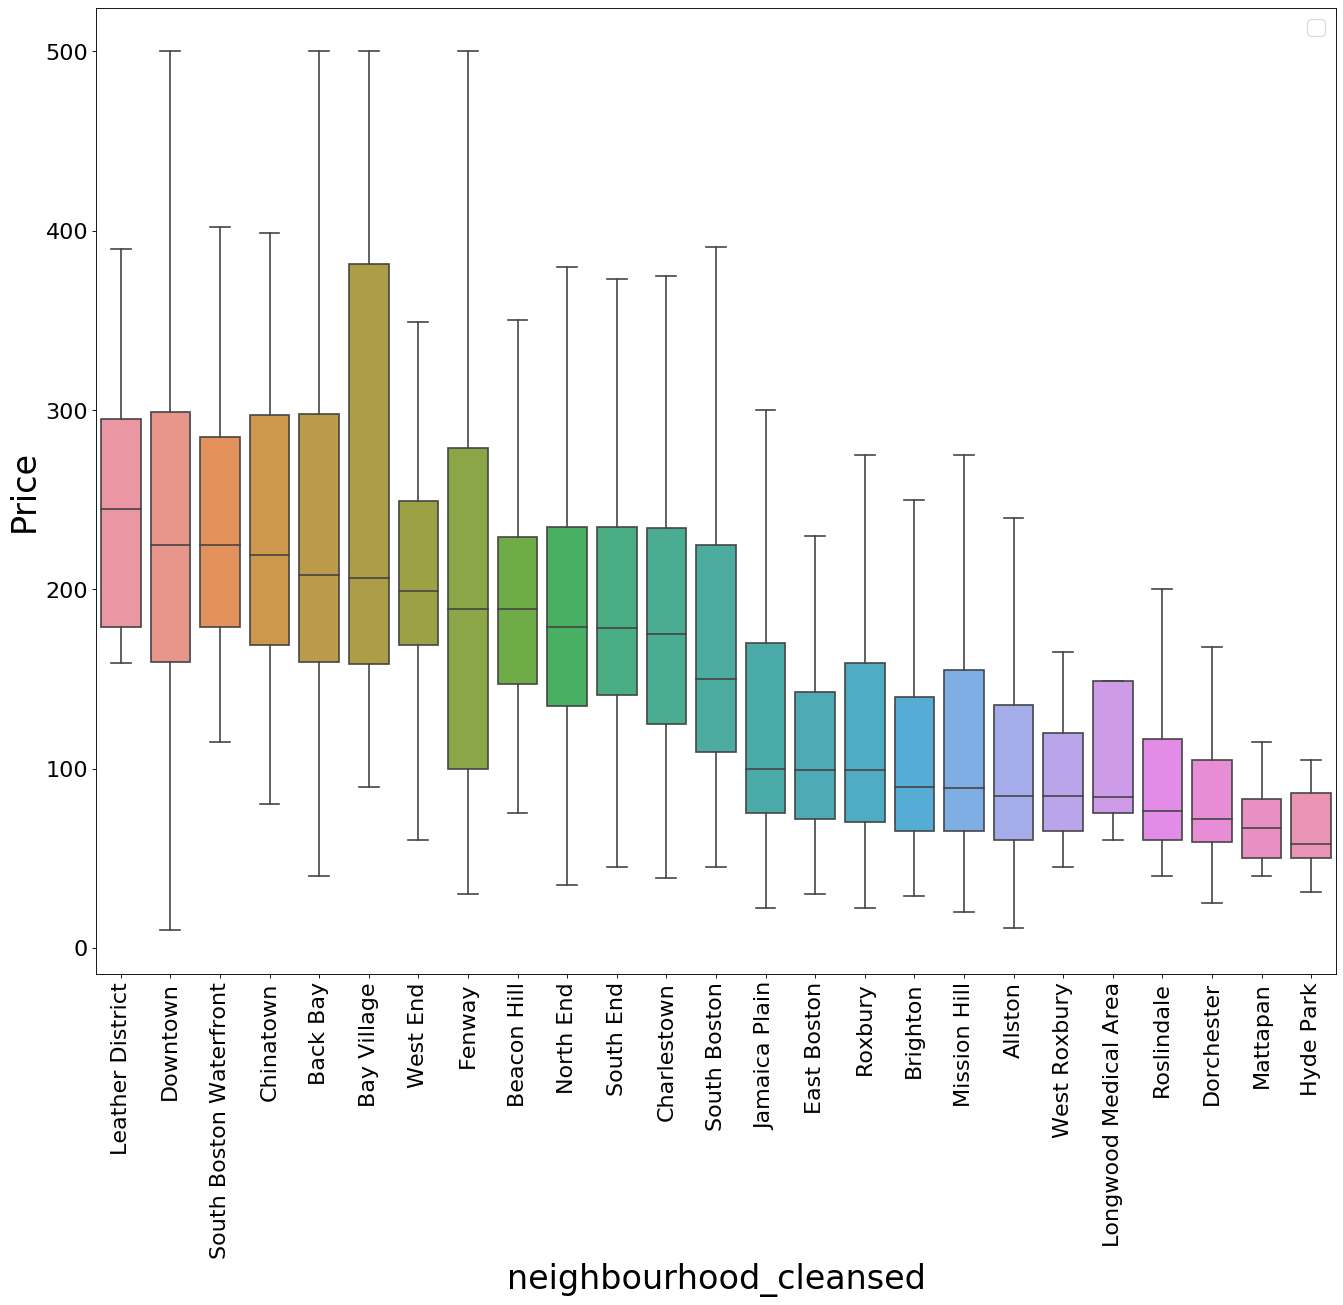

In [34]:
# Compare prices to the neighborhoods they occur in

# First part to get a sort list that gets a descending order of median price
order = [0,0]
for hood in tqdm(listings['neighbourhood_cleansed'].unique()):
    df = listings[listings['neighbourhood_cleansed'] == hood]
    median = df['price'].median()
    row = [hood, median]
    row = np.array(row)
    order = np.vstack([order, row])
order = pd.DataFrame(order, columns = ['neighborhood', 'median_price'])
order['median_price'] = order['median_price'].astype(float)
order = order.drop(order.index[0])
order = order.sort_values(by = 'median_price', ascending = False)
sort_order = list(order['neighborhood'])

fig = plt.figure(figsize=(20, 16), dpi=80)
sns.boxplot(x = 'neighbourhood_cleansed', y = 'price', data = listings, showfliers = False, order = sort_order)
plt.ylabel('Price', fontsize=30)
plt.xlabel('neighbourhood_cleansed', fontsize=30)
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20);

In [35]:
df = listings

    
# Gettin summary statistics
stats.f_oneway(df['price'][df['neighbourhood_cleansed'] == 'Roslindale'], 
             df['price'][df['neighbourhood_cleansed'] == 'Jamaica Plain'],
              df['price'][df['neighbourhood_cleansed'] == 'Mission Hill'],
              df['price'][df['neighbourhood_cleansed'] == 'Longwood Medical Area'],
              df['price'][df['neighbourhood_cleansed'] == 'Bay Village'],
              df['price'][df['neighbourhood_cleansed'] == 'Leather District'],
              df['price'][df['neighbourhood_cleansed'] == 'Chinatown'],
              df['price'][df['neighbourhood_cleansed'] == 'North End'],
              df['price'][df['neighbourhood_cleansed'] == 'Roxbury'],
              df['price'][df['neighbourhood_cleansed'] == 'South End'],
              df['price'][df['neighbourhood_cleansed'] == 'Back Bay'],
              df['price'][df['neighbourhood_cleansed'] == 'East Boston'],
              df['price'][df['neighbourhood_cleansed'] == 'Charlestown'],
              df['price'][df['neighbourhood_cleansed'] == 'West End'],
              df['price'][df['neighbourhood_cleansed'] == 'Beacon Hill'],
              df['price'][df['neighbourhood_cleansed'] == 'Downtown'],
              df['price'][df['neighbourhood_cleansed'] == 'Fenway'],
              df['price'][df['neighbourhood_cleansed'] == 'Brighton'],
              df['price'][df['neighbourhood_cleansed'] == 'West Roxbury'],
              df['price'][df['neighbourhood_cleansed'] == 'Hyde Park'],
              df['price'][df['neighbourhood_cleansed'] == 'Mattapan'],
              df['price'][df['neighbourhood_cleansed'] == 'Dorchester'],
              df['price'][df['neighbourhood_cleansed'] == 'South Boston Waterfront'],
              df['price'][df['neighbourhood_cleansed'] == 'South Boston'],
              df['price'][df['neighbourhood_cleansed'] == 'Allston'])

F_onewayResult(statistic=48.55190884120021, pvalue=7.711190597666385e-198)

No handles with labels found to put in legend.


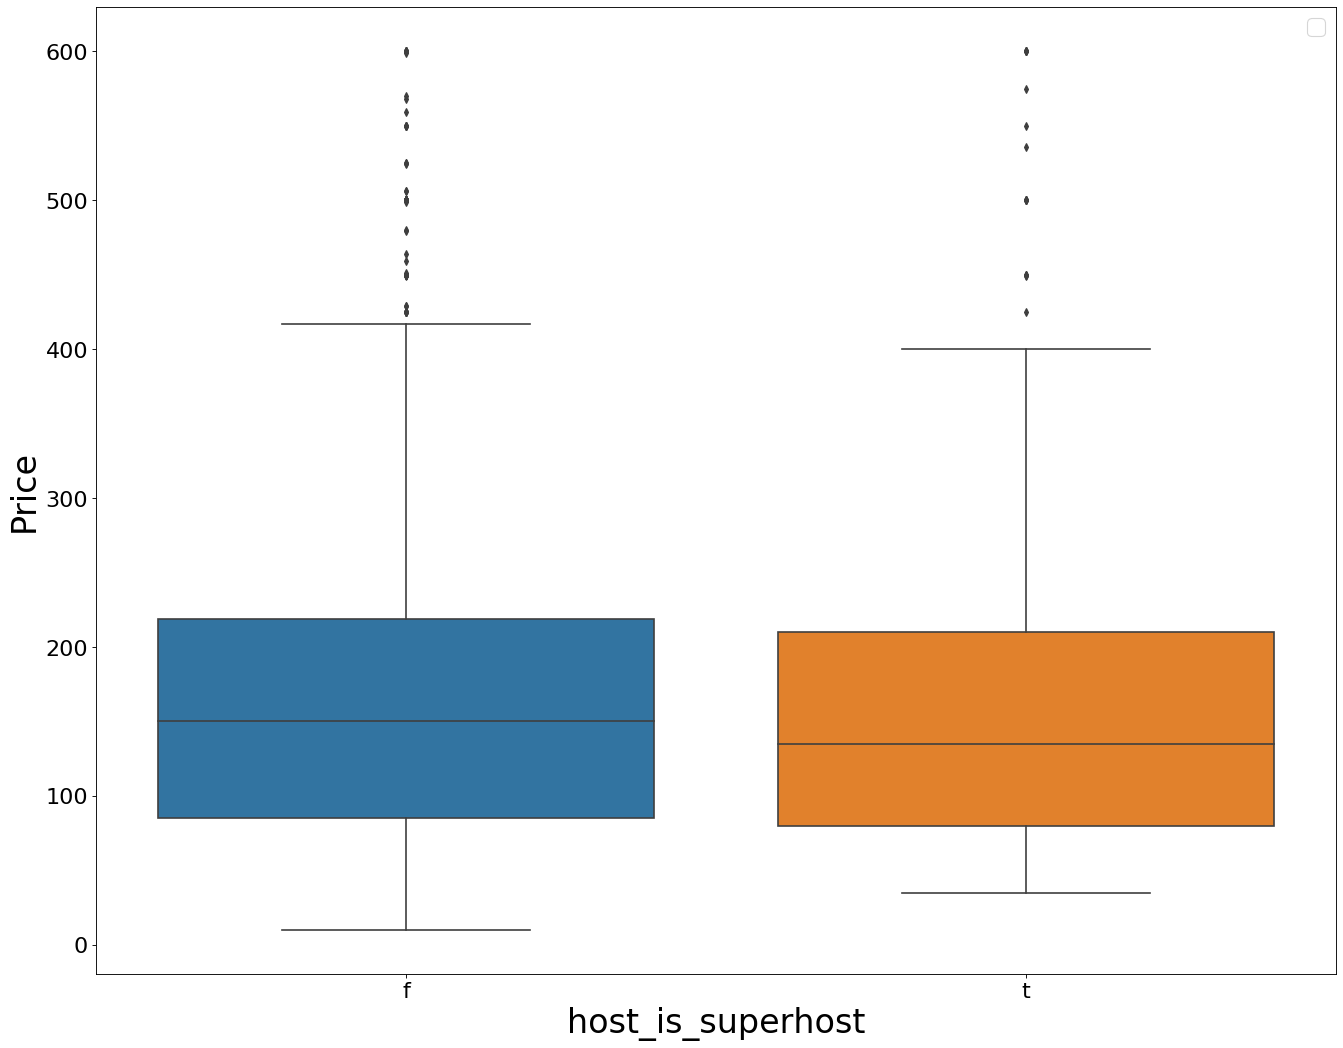

In [36]:
fig = plt.figure(figsize=(20, 16), dpi=80)
sns.boxplot(y='price', x='host_is_superhost', data=listings)
plt.ylabel('Price', fontsize=30)
plt.xlabel('host_is_superhost', fontsize=30)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20)

Text(0.5, 1.0, 'Price per Superhost Designation')

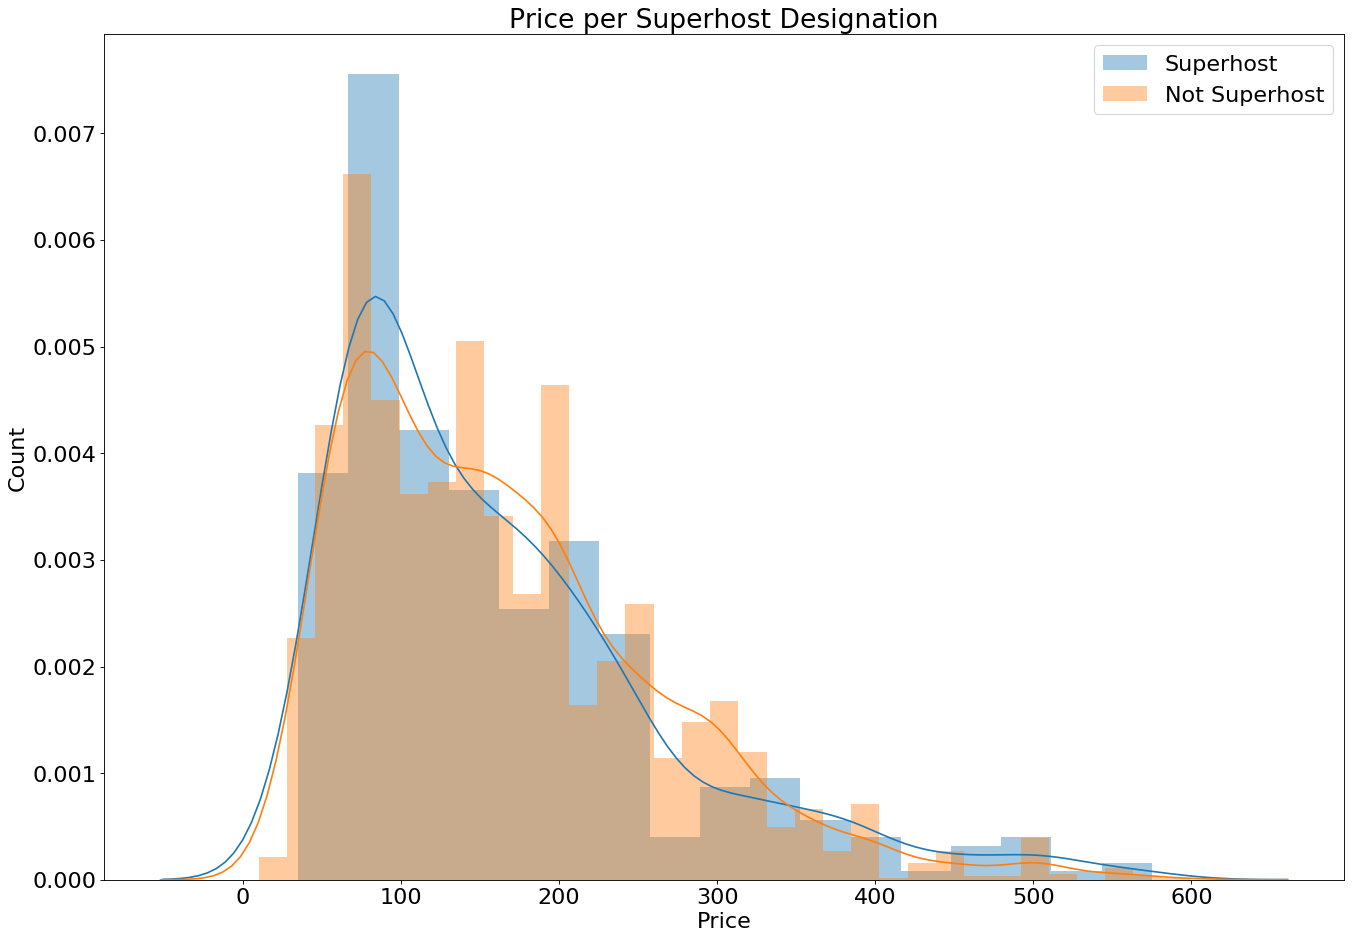

In [37]:
fig = plt.figure(figsize=(20, 14), dpi=80)
sns.distplot(listings['price'][(listings['host_is_superhost']=='t') & (listings['price']<600)], label='Superhost')
sns.distplot(listings['price'][(listings['host_is_superhost']=='f') & (listings['price']<600)], label = 'Not Superhost')
plt.xlabel('Price', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize = 20)
plt.title('Price per Superhost Designation', fontsize = 24)

In [38]:
df = listings
x = df['price'][df['host_is_superhost'] == 't']
y = df['price'][df['host_is_superhost'] == 'f']
scipy.stats.mannwhitneyu(x, y, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=614933.5, pvalue=0.2060425699017926)

100%|██████████| 14/14 [00:00<00:00, 114.56it/s]
No handles with labels found to put in legend.


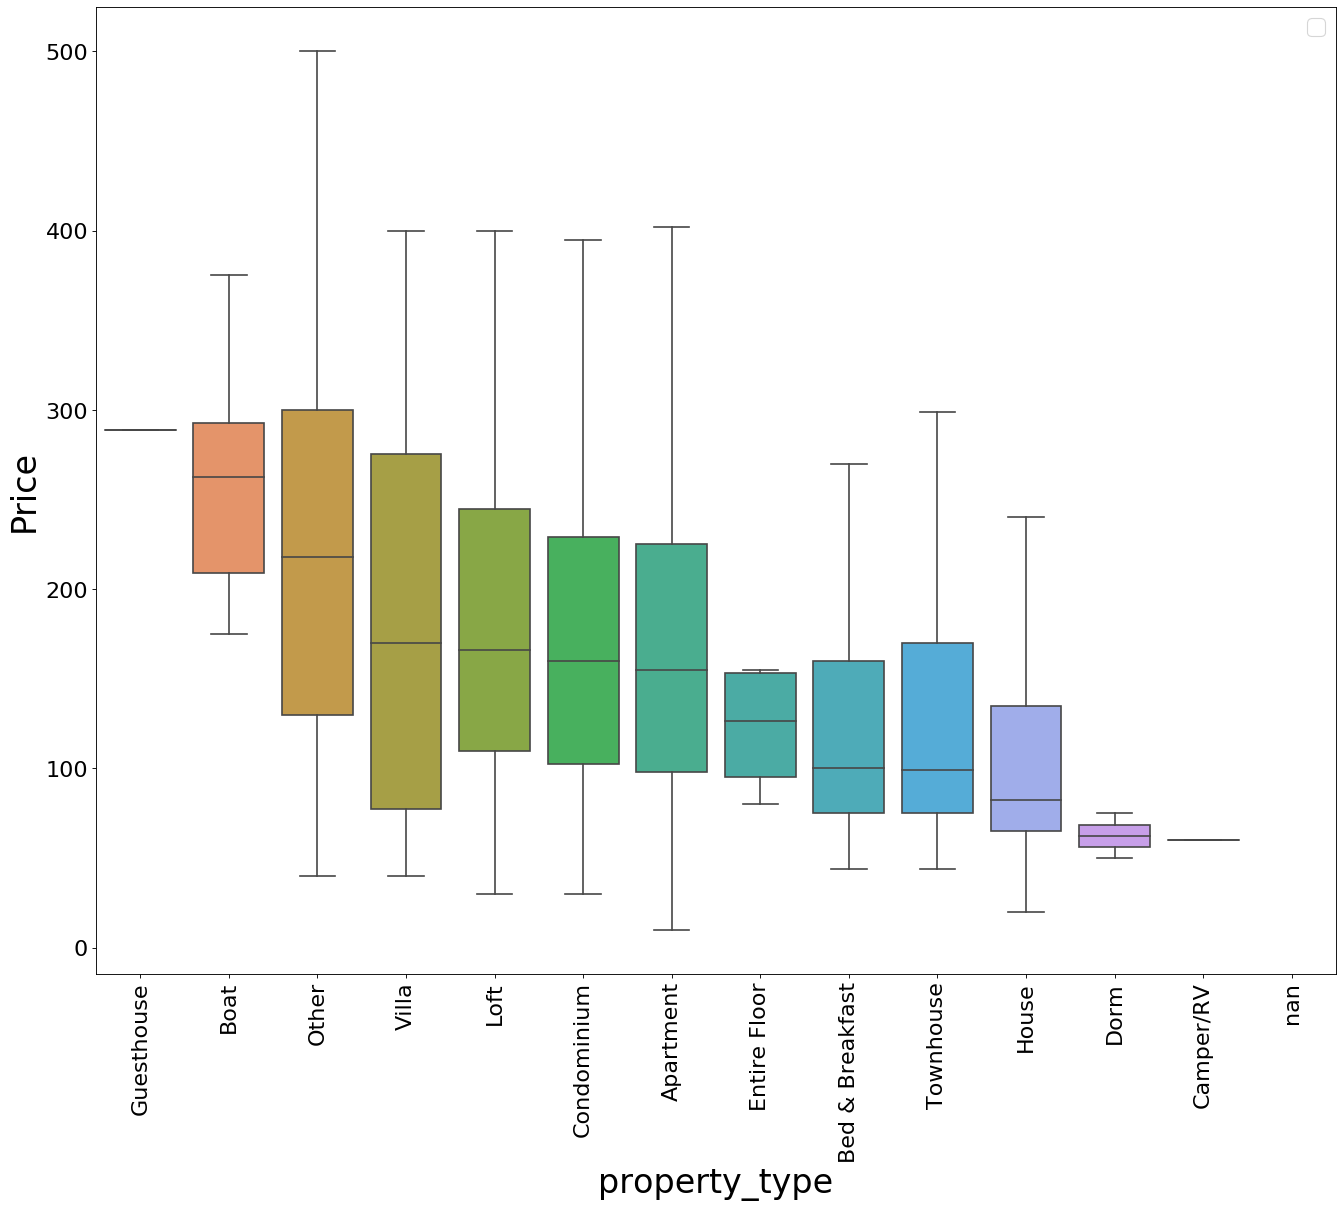

In [39]:
# Compare prices to the property types

# First part to get a sort list that gets a descending order of median price
order = [0,0]
for hood in tqdm(listings['property_type'].unique()):
    df = listings[listings['property_type'] == hood]
    median = df['price'].median()
    row = [hood, median]
    row = np.array(row)
    order = np.vstack([order, row])
order = pd.DataFrame(order, columns = ['property_type', 'median_price'])
order['median_price'] = order['median_price'].astype(float)
order = order.drop(order.index[0])
order = order.sort_values(by = 'median_price', ascending = False)
sort_order = list(order['property_type'])

fig = plt.figure(figsize=(20, 16), dpi=80)
sns.boxplot(x = 'property_type', y = 'price', data = listings, showfliers = False, order = sort_order)
plt.ylabel('Price', fontsize=30)
plt.xlabel('property_type', fontsize=30)
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20);

In [40]:
df = listings

    
# Gettin summary statistics
stats.f_oneway(df['price'][df['property_type'] == 'House'], 
             df['price'][df['property_type'] == 'Apartment'],
              df['price'][df['property_type'] == 'Condominium'],
              df['price'][df['property_type'] == 'Villa'],
              df['price'][df['property_type'] == 'Bed & Breakfast'],
              df['price'][df['property_type'] == 'Townhouse'],
              df['price'][df['property_type'] == 'Entire Floor'],
              df['price'][df['property_type'] == 'Loft'],
              df['price'][df['property_type'] == 'Guesthouse'],
              df['price'][df['property_type'] == 'Boat'],
              df['price'][df['property_type'] == 'Dorm'],
              df['price'][df['property_type'] == 'Other'],
              df['price'][df['property_type'] == 'Camper/RV'])

F_onewayResult(statistic=13.800958071140178, pvalue=1.9849715287408883e-28)

100%|██████████| 3/3 [00:00<00:00, 344.23it/s]
No handles with labels found to put in legend.


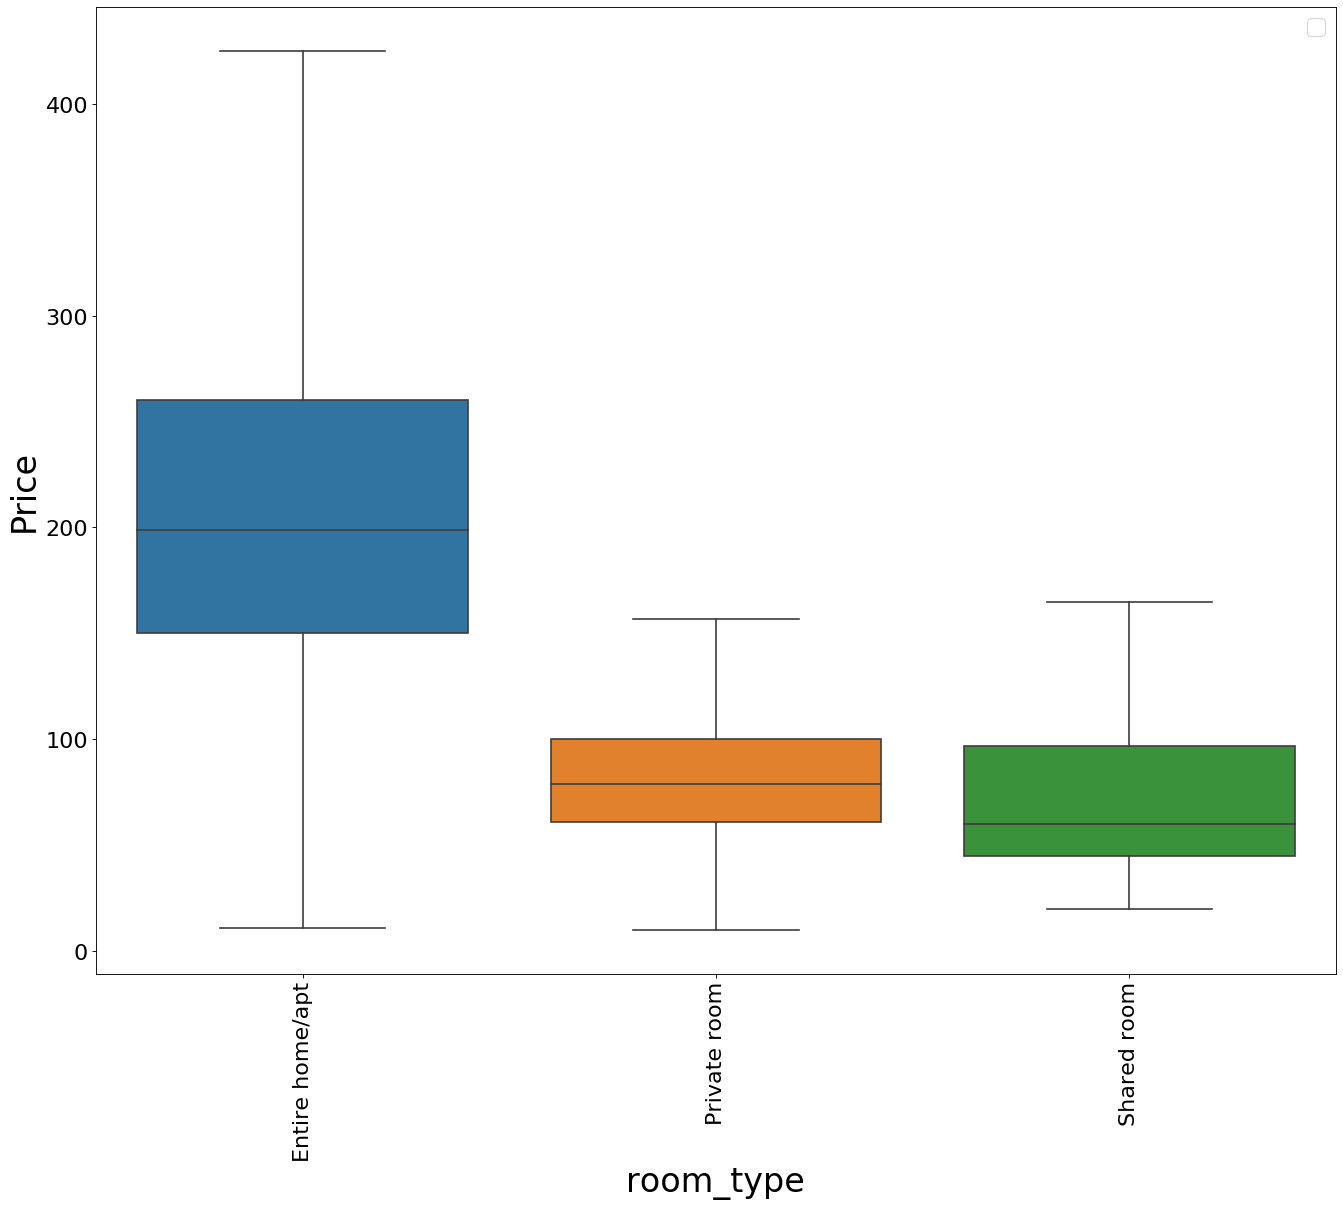

In [41]:
# Compare prices to the room types

# First part to get a sort list that gets a descending order of median price
order = [0,0]
for hood in tqdm(listings['room_type'].unique()):
    df = listings[listings['room_type'] == hood]
    median = df['price'].median()
    row = [hood, median]
    row = np.array(row)
    order = np.vstack([order, row])
order = pd.DataFrame(order, columns = ['room_type', 'median_price'])
order['median_price'] = order['median_price'].astype(float)
order = order.drop(order.index[0])
order = order.sort_values(by = 'median_price', ascending = False)
sort_order = list(order['room_type'])

fig = plt.figure(figsize=(20, 16), dpi=80)
sns.boxplot(x = 'room_type', y = 'price', data = listings, showfliers = False, order = sort_order)
plt.ylabel('Price', fontsize=30)
plt.xlabel('room_type', fontsize=30)
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20);

In [42]:
df = listings

    
# Gettin summary statistics
stats.f_oneway(df['price'][df['room_type'] == 'Entire home/apt'], 
             df['price'][df['room_type'] == 'Private room'],
              df['price'][df['room_type'] == 'Shared room'])

F_onewayResult(statistic=1016.8342314294893, pvalue=0.0)

100%|██████████| 5/5 [00:00<00:00, 387.28it/s]
No handles with labels found to put in legend.


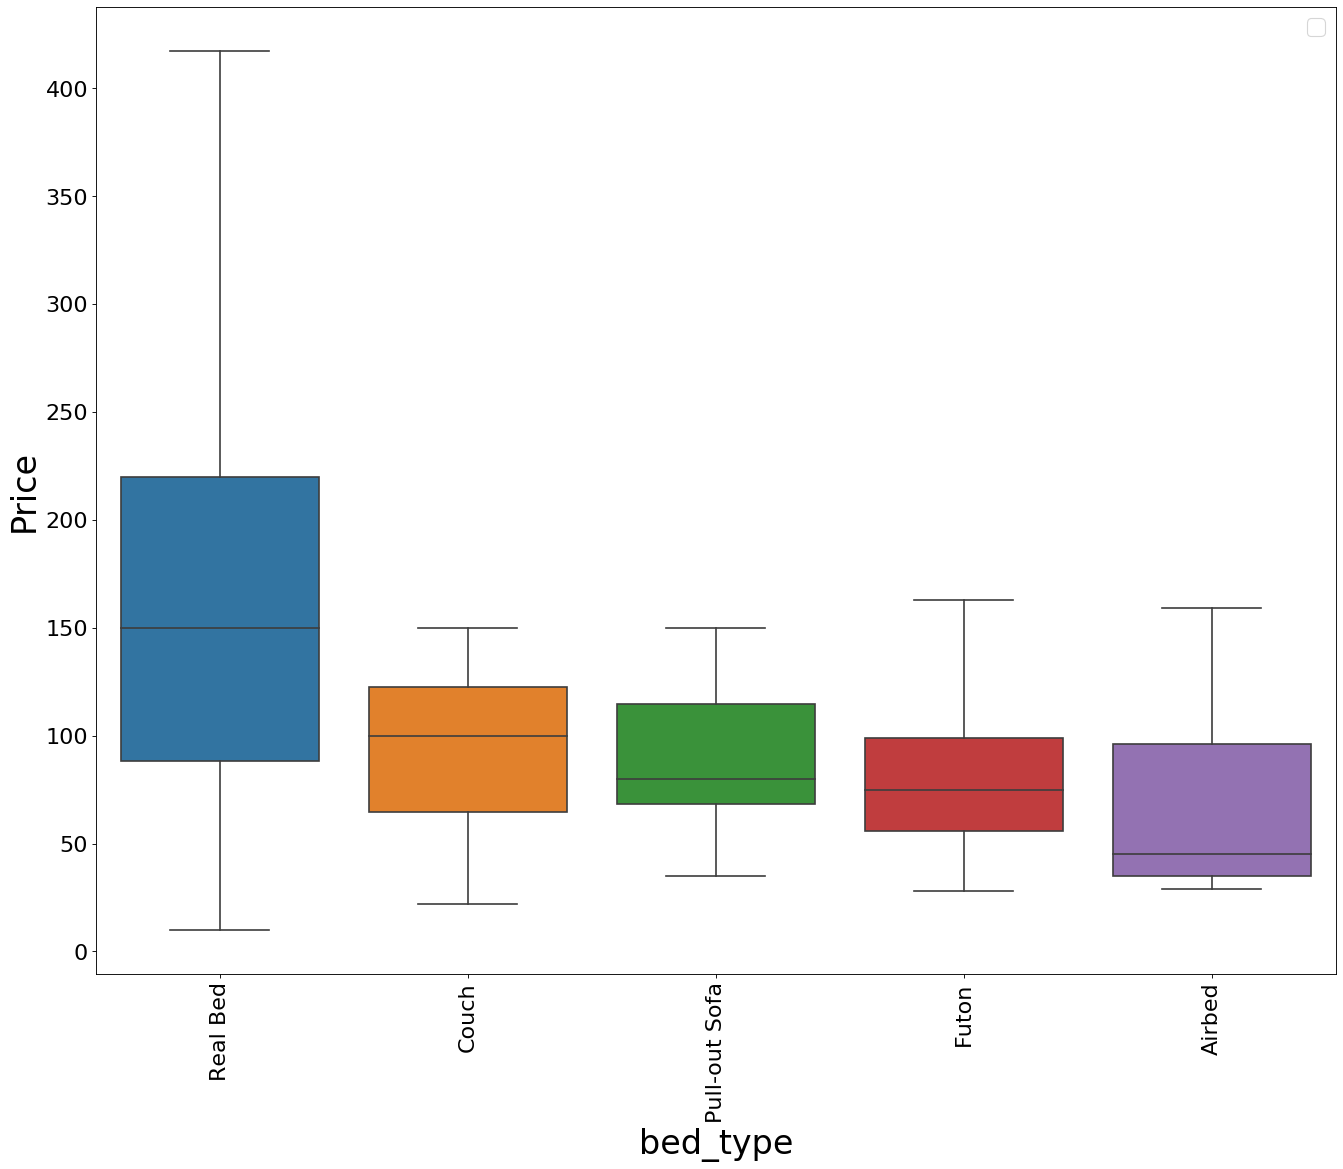

In [43]:
# Compare prices to the bed types

# First part to get a sort list that gets a descending order of median price
order = [0,0]
for hood in tqdm(listings['bed_type'].unique()):
    df = listings[listings['bed_type'] == hood]
    median = df['price'].median()
    row = [hood, median]
    row = np.array(row)
    order = np.vstack([order, row])
order = pd.DataFrame(order, columns = ['bed_type', 'median_price'])
order['median_price'] = order['median_price'].astype(float)
order = order.drop(order.index[0])
order = order.sort_values(by = 'median_price', ascending = False)
sort_order = list(order['bed_type'])

fig = plt.figure(figsize=(20, 16), dpi=80)
sns.boxplot(x = 'bed_type', y = 'price', data = listings, showfliers = False, order = sort_order)
plt.ylabel('Price', fontsize=30)
plt.xlabel('bed_type', fontsize=30)
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20);

In [44]:
df = listings

    
# Gettin summary statistics
stats.f_oneway(df['price'][df['bed_type'] == 'Real Bed'], 
             df['price'][df['bed_type'] == 'Couch'],
              df['price'][df['bed_type'] == 'Pull-out Sofa'],
              df['price'][df['bed_type'] == 'Futon'],
              df['price'][df['bed_type'] == 'Airbed'])

F_onewayResult(statistic=20.475930877880238, pvalue=1.0725247489459794e-16)

No handles with labels found to put in legend.


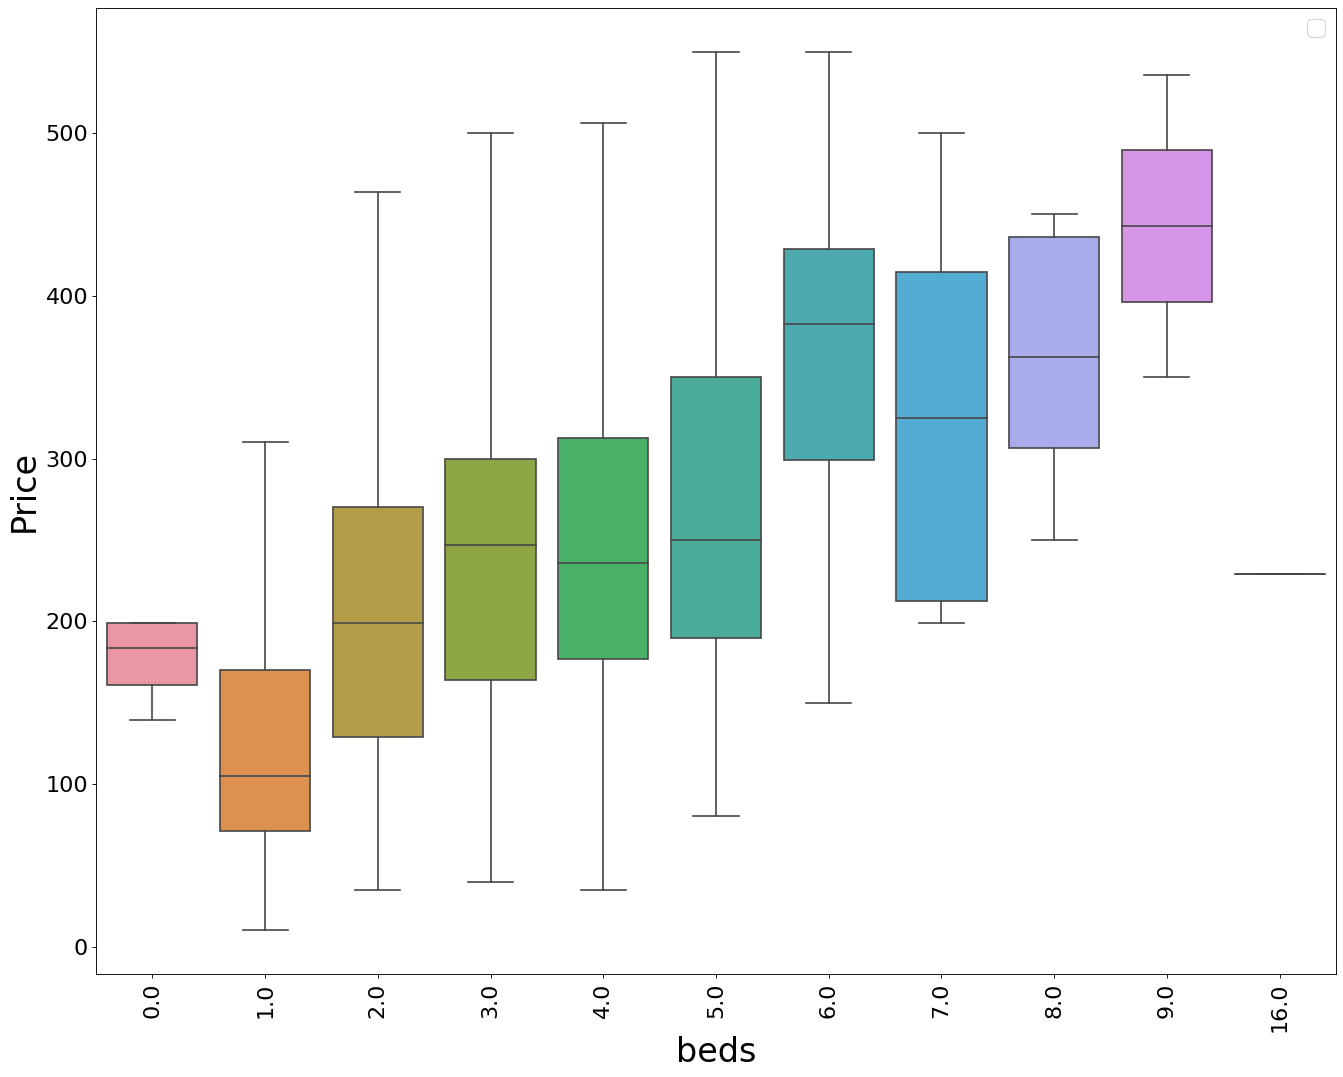

In [45]:
# Compare prices to the number of beds

# First part to get a sort list that gets a descending order of median price
fig = plt.figure(figsize=(20, 16), dpi=80)
sns.boxplot(x = 'beds', y = 'price', data = listings, showfliers = False)
plt.ylabel('Price', fontsize=30)
plt.xlabel('beds', fontsize=30)
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20);

In [46]:
type(listings['beds'][5])

numpy.float64

In [47]:
df = listings

    
# Gettin summary statistics
stats.f_oneway(df['price'][df['beds'] == 0.0], 
             df['price'][df['beds'] == 1.0],
              df['price'][df['beds'] == 2.0],
              df['price'][df['beds'] == 3.0],
              df['price'][df['beds'] == 4.0],
              df['price'][df['beds'] == 5.0],
              df['price'][df['beds'] == 6.0],
              df['price'][df['beds'] == 7.0],
              df['price'][df['beds'] == 8.0],
              df['price'][df['beds'] == 9.0],
              df['price'][df['beds'] == 16.0])

F_onewayResult(statistic=113.55123685115176, pvalue=2.484652470369438e-205)

In [48]:
# Change date data to datetime

boston['date'] = [datetime.strptime(x, '%Y-%m-%d') for x in boston['date']]

In [49]:
boston['price'] = boston['price_y'].map(lambda p: int(p[1:-3].replace(",", "")))

In [50]:
# Grouping data based on neighborhood and taking the mean of the data to see how price changes throughout the year

grouped = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for hood in tqdm(boston['neighbourhood_cleansed'].unique()):
    b = boston[boston['neighbourhood_cleansed'] == hood]    
    b.index = pd.to_datetime(b['date'],format='%y-%m-%d')
    g = b.groupby(by=b.index.month).mean()
    g['neighborhood'] = hood
    g['date'] = g.index
    h = np.array(g)
    grouped = np.vstack([grouped, h])
grouped = pd.DataFrame(grouped, columns = g.columns)
grouped = grouped.drop(grouped.index[0])

100%|██████████| 25/25 [00:01<00:00, 13.48it/s]


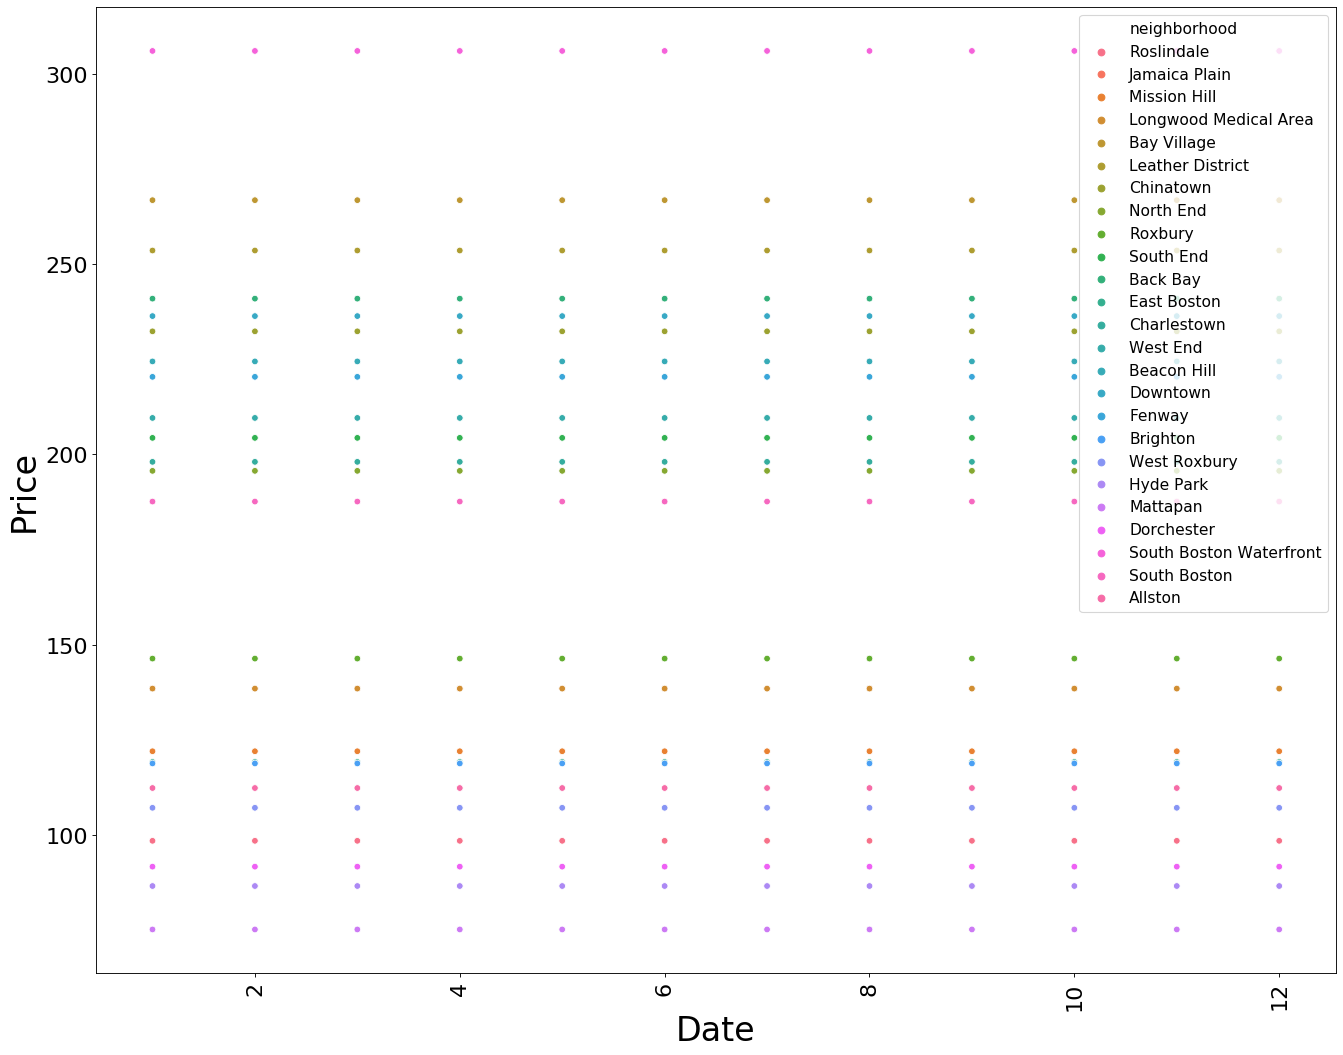

In [51]:
fig = plt.figure(figsize=(20, 16), dpi=80)
sns.scatterplot(x = 'date', y = 'price', data = grouped, hue = 'neighborhood')
plt.ylabel('Price', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=14);

### From this last plot, we can see that prices don't change throughout the year in each neighborhood


In [52]:
# Grouping data based on neighborhood and taking the sum of the data to see how the total number of stays changes
# with time. 

grouped_1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for hood in tqdm(boston['neighbourhood_cleansed'].unique()):
    b = boston[boston['neighbourhood_cleansed'] == hood]    
    b.index = pd.to_datetime(b['date'],format='%y-%m-%d')
    g = b.groupby(by=b.index.month).sum()
    g['neighborhood'] = hood
    g['date'] = g.index
    h = np.array(g)
    grouped_1 = np.vstack([grouped_1, h])
grouped_1 = pd.DataFrame(grouped_1, columns = g.columns)
grouped_1 = grouped_1.drop(grouped_1.index[0])

100%|██████████| 25/25 [00:01<00:00, 13.82it/s]


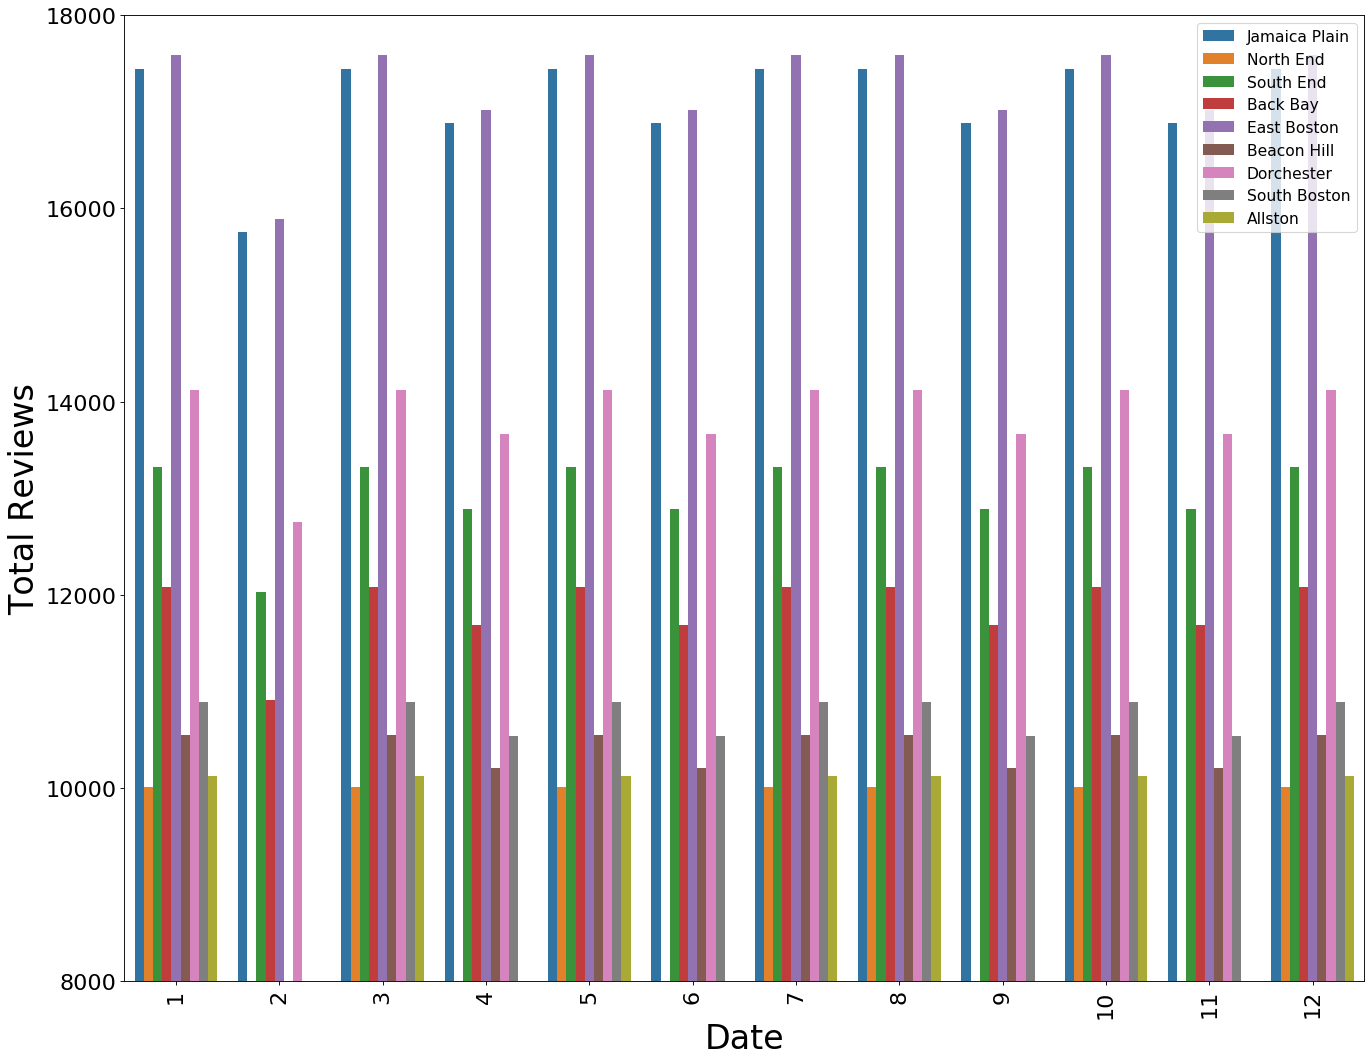

In [53]:
fig = plt.figure(figsize=(20, 16), dpi=80)
sns.barplot(x = 'date', y = 'reviews_per_month', data = grouped_1[grouped_1['reviews_per_month']>10000], hue = 'neighborhood')
plt.ylabel('Total Reviews', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.ylim(8000,18000)
plt.legend(fontsize=14);

In [54]:
# Grouping data based on neighborhood and taking the mean of the data to see how the availability of listings 
# changes with time. The lower the availability number is, the more often it was booked. 

grouped_2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for hood in tqdm(boston['neighbourhood_cleansed'].unique()):
    b = boston[boston['neighbourhood_cleansed'] == hood]    
    b.index = pd.to_datetime(b['date'],format='%y-%m-%d')
    g = b.groupby(by=b.index.month).mean()
    g['neighborhood'] = hood
    g['date'] = g.index
    h = np.array(g)
    grouped_2 = np.vstack([grouped_2, h])
grouped_2 = pd.DataFrame(grouped_2, columns = g.columns)
grouped_2 = grouped_2.drop(grouped_2.index[0])

100%|██████████| 25/25 [00:02<00:00, 12.02it/s]


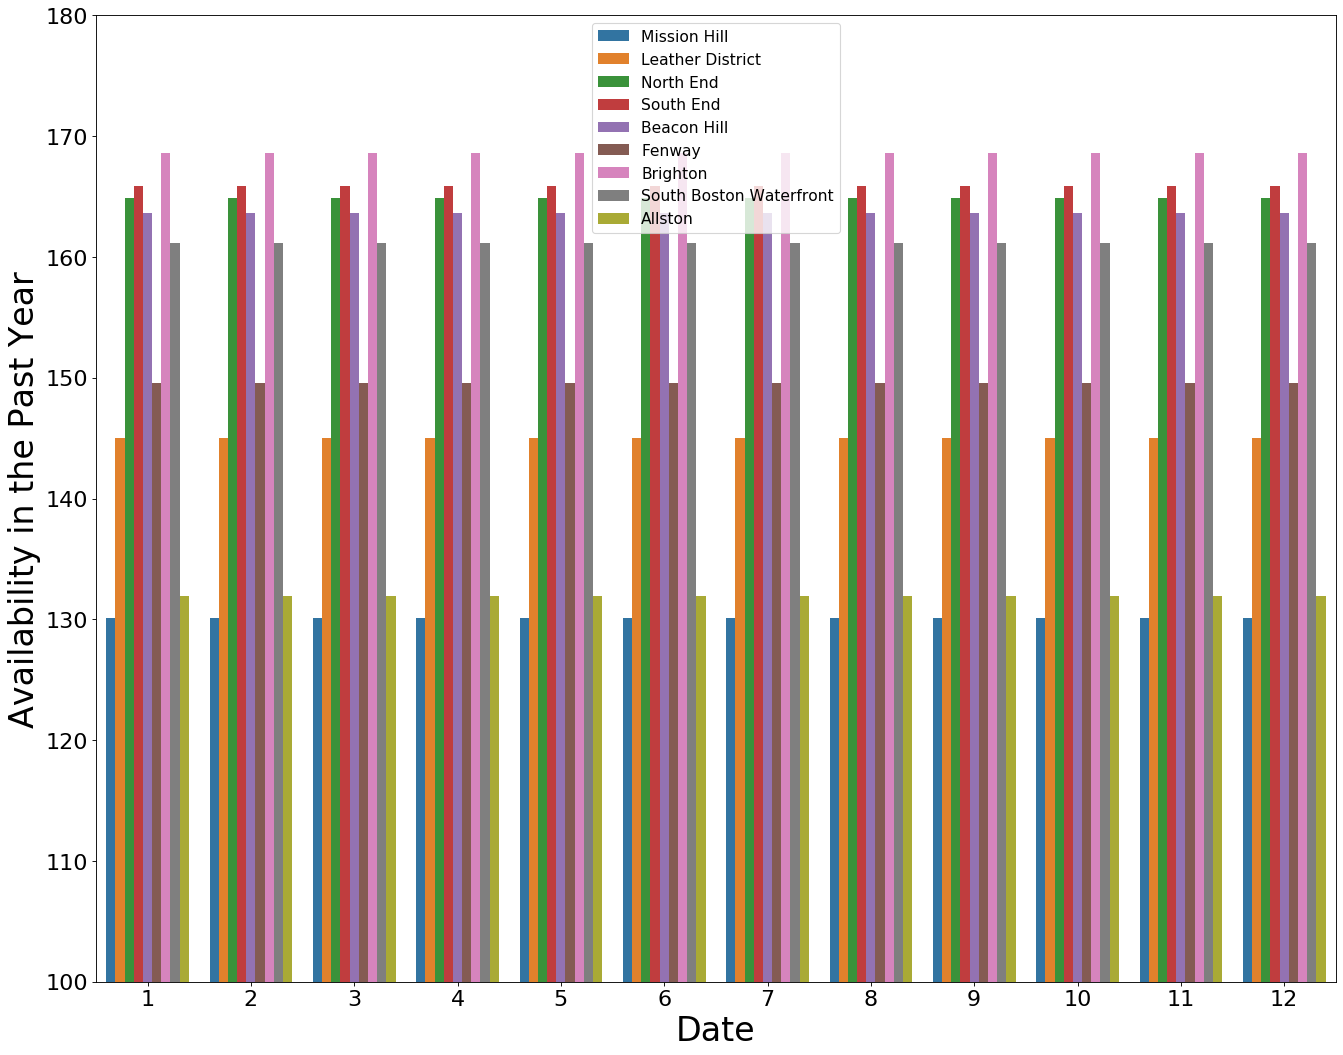

In [55]:
fig = plt.figure(figsize=(20, 16), dpi=80)
sns.barplot(x = 'date', y = 'availability_365', data = grouped_2[grouped_2['availability_365']<180], hue = 'neighborhood')
plt.ylabel('Availability in the Past Year', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylim(100,180)
plt.legend(fontsize=14);

In [56]:
# LOOK AT TOP NEIGHBORHOODS IN THE LAST TWO GRAPHS AND COMPARE THAT LIST

### We can see that there a few factors that affect the price of the home. Let's see if we can build a model.

## Let's Build a Model To Predict Home Prices


In [57]:
listings = pd.read_csv('/home/steven/Udacity_Class/Project1_Blog_Post/boston/listings.csv')

In [58]:
listings['price'] = listings['price'].map(lambda p: int(p[1:-3].replace(",", "")))
listings['amenities'] = listings['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")])
)

In [59]:
np.concatenate(listings['amenities'].map(lambda amns: amns.split("|")).values)

array(['TV', 'Wireless Internet', 'Kitchen', ..., 'Essentials',
       'translation missing: en.hosting_amenity_49',
       'translation missing: en.hosting_amenity_50'], dtype='<U42')

In [60]:
amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split("|")).values))
amenities_matrix = np.array([listings['amenities'].map(lambda amns: amn in amns).values for amn in amenities])

In [61]:
features = listings[['host_listings_count', 'host_total_listings_count', 'accommodates', 
                     'bathrooms', 'bedrooms', 'beds', 'price', 'guests_included', 'number_of_reviews',
                     'review_scores_rating']]

In [62]:
listings['amenities'].map(lambda amns: amns.split("|")).head()

0    [TV, Wireless Internet, Kitchen, Free Parking ...
1    [TV, Internet, Wireless Internet, Air Conditio...
2    [TV, Cable TV, Wireless Internet, Air Conditio...
3    [TV, Internet, Wireless Internet, Air Conditio...
4    [Internet, Wireless Internet, Air Conditioning...
Name: amenities, dtype: object

In [63]:
# The [1:] is because the first amenity our parser finds is a junk empty string---"".
np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split("|"))))[1:]

array(['24-Hour Check-in', 'Air Conditioning', 'Breakfast',
       'Buzzer/Wireless Intercom', 'Cable TV', 'Carbon Monoxide Detector',
       'Cat(s)', 'Dog(s)', 'Doorman', 'Dryer', 'Elevator in Building',
       'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher',
       'First Aid Kit', 'Free Parking on Premises',
       'Free Parking on Street', 'Gym', 'Hair Dryer', 'Hangers',
       'Heating', 'Hot Tub', 'Indoor Fireplace', 'Internet', 'Iron',
       'Kitchen', 'Laptop Friendly Workspace', 'Lock on Bedroom Door',
       'Other pet(s)', 'Paid Parking Off Premises', 'Pets Allowed',
       'Pets live on this property', 'Pool', 'Safety Card', 'Shampoo',
       'Smoke Detector', 'Smoking Allowed', 'Suitable for Events', 'TV',
       'Washer', 'Washer / Dryer', 'Wheelchair Accessible',
       'Wireless Internet', 'translation missing: en.hosting_amenity_49',
       'translation missing: en.hosting_amenity_50'], dtype='<U42')

In [64]:
amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split("|"))))[1:]
amenity_arr = np.array([listings['amenities'].map(lambda amns: amn in amns) for amn in amenities])
amenity_arr

array([[False, False, False, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False,  True],
       [False, False,  True, ...,  True, False,  True],
       [False, False,  True, ...,  True,  True,  True]])

In [65]:
features = pd.concat([features, pd.DataFrame(data=amenity_arr.T, columns=amenities)], axis=1)

In [66]:
for tf_feature in ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']:
    features[tf_feature] = listings[tf_feature].map(lambda s: False if s == "f" else True)

In [67]:
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
    features = pd.concat([features, pd.get_dummies(listings[categorical_feature])], axis=1)

In [68]:
for col in features.columns[features.isnull().any()]:
    features[col] = features[col].fillna(features[col].median())

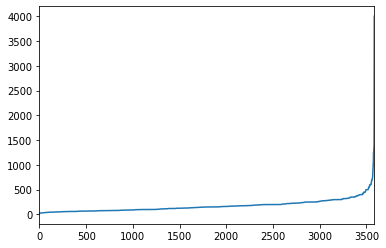

In [69]:
features['price'].sort_values().reset_index(drop=True).plot()

In [70]:
fitters = features.query('price <= 600')

In [71]:
clf = LinearRegression()
y = fitters['price']
clf.fit(fitters.drop('price', axis='columns'), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [72]:
y_pred = clf.predict(fitters.drop('price', axis='columns'))

In [73]:
mse = sklearn.metrics.mean_squared_error(y, y_pred)
mse

3526.992822148997

In [74]:
root_mse = mse**(1/2)
root_mse

59.3884906539053

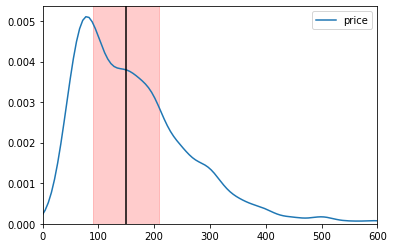

In [75]:
sns.kdeplot(y)
ax = plt.gca()
ax.set_xlim([0, 600])
plt.axvline(y.median(), c='black')
ax.add_patch(
    patches.Rectangle((y.median() - root_mse, 0), 2*root_mse, 0.006,
                      color='r', alpha=0.2)
)

In [76]:
r_squared = sklearn.metrics.r2_score(y, y_pred)
r_squared

0.6553776855623248

In [77]:
# Print coefficients of each feature

coefs = list(zip(clf.coef_, fitters.drop('price', axis='columns')))
coefs

[(-0.004109792960536603, 'host_listings_count'),
 (-0.004109792956192682, 'host_total_listings_count'),
 (6.34276387324327, 'accommodates'),
 (11.279345997228225, 'bathrooms'),
 (35.71774234079301, 'bedrooms'),
 (2.855125615494149, 'beds'),
 (6.495433991147493, 'guests_included'),
 (-0.19441748772978595, 'number_of_reviews'),
 (0.2386008955112402, 'review_scores_rating'),
 (-9.099387555501128, '24-Hour Check-in'),
 (10.940518679608129, 'Air Conditioning'),
 (9.117717296571197, 'Breakfast'),
 (1.2097691545158735, 'Buzzer/Wireless Intercom'),
 (3.6334737157119044, 'Cable TV'),
 (2.6631348011708167, 'Carbon Monoxide Detector'),
 (-10.3194992947657, 'Cat(s)'),
 (1.1550010734824383, 'Dog(s)'),
 (19.60912860588048, 'Doorman'),
 (-0.7864908617434629, 'Dryer'),
 (7.07278896179812, 'Elevator in Building'),
 (-2.8391620377310254, 'Essentials'),
 (1.8277910093080374, 'Family/Kid Friendly'),
 (-1.0317860513566863, 'Fire Extinguisher'),
 (3.6518403356416407, 'First Aid Kit'),
 (-8.314310842095594, 